# 여러분의 MBTI는?
![alt text](a.png "Title")

In [1]:
# 필요 패키지 호출
!pip install psycopg2-binary
!pip install psycopg2
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
import time
import re
import pyautogui
import random
import psycopg2
import pandas as pd
import urllib.request
import json

### DB 불러오기

In [2]:
# DB 생성
conn_str = "host=localhost dbname=project user=postgres password=admin port=5432"

try:
    conn = psycopg2.connect(conn_str)
    print("=== 접속 성공 =====")
# except:
#   print("접속오류 !!")

except psycopg2.DatabaseError as db_err:
    print("접속오류 !!")
    print(db_err)
    
cur = conn.cursor() # cursor 인스턴스 : 데이터 조작용 생성


=== 접속 성공 =====


### instagram 크롤링을 위한 함수 정의 및 준비

In [ ]:
## 리스트 
MBTI = {"#ISTJ":0,"#ISTP":0,"#ISFJ":0,"#ISFP":0,"#INTJ":0,"#INTP":0,"#INFJ":0,"#INFP":0,
        "#ESTJ":0,"#ESTP":0,"#ESFJ":0,"#ESFP":0,"#ENTJ":0,"#ENTP":0,"#ENFJ":0,"#ENFP":0}

mbti = list(MBTI.keys())

Mbti = []
for i in range(mbti):
        Mbti.append(i.replace('#',''))

In [ ]:
# 함수 정의 : 검색어 조건에 따른 url 생성
def insta_searching(word):
    url = f"https://www.instagram.com/explore/tags/{word}"
    return url

In [ ]:
# 함수정의 : 열린 페이지에서 첫번째 게시물 클릭 + sleep 메소드 통하여 시차 두기
def select_first(driver):
    first = driver.find_elements_by_css_selector('div._9AhH0')[0]
    first.click()
    time.sleep(random.randint(2,5))

In [ ]:
# 함수 정의 : 본문 내용, 작성일자, 좋아요 수, 해시태그 가져오기
import re
from bs4 import BeautifulSoup

def get_content(driver):
    html = driver.page_source
    soup = BeautifulSoup(html, 'lxml')
    # 본문 내용
    try:
        content = soup.select('div.C4VMK > span')[0].text
    except:
        content = " "

    # 해시태그
    tags = re.findall(r'#[^\s#,\\]+', content)

    # 작성일자
    date = soup.select('time._1o9PC.Nzb55')[0]['datetime'][:10]
    
    # 좋아요
    try:
        like = soup.select('div._7UhW9.xLCgt.qyrsm')[0].text
    except:
        like = 0
    

    return content, tags,date,like

In [ ]:
# 첫 번째 게시물 클릭 후 다음 게시물 클릭
def move_next(driver):
    right = driver.find_element_by_css_selector("div.l8mY4.feth3")
    right.click()
    time.sleep(random.randint(3,5))

### instagram 크롤링 코드

In [ ]:
# 크롤링 시작
"""
driver.get(url)을 통해 검색 페이지 접속하고,
target 변수에 크롤링할 게시글의 수를 바인딩
"""

## ENFP, INFP, INFJ

# 인스타그램 로그인을 위한 계정 정보
username = pyautogui.prompt("인스타 아이디를 입력하세요.")
userpw = pyautogui.prompt("비밀번호를 입력하세요.")
time.sleep(3)

# 크롬 브라우저 열기
driver = webdriver.Chrome(r"C:\chromedriver.exe")
driver.get('https://www.instagram.com')
# loginUrl = 'https://www.instagram.com/accounts/login/'
time.sleep(random.randint(3,5))

# login
driver.find_element_by_name('username').send_keys(username)
driver.find_element_by_name('password').send_keys(userpw)
time.sleep(random.randint(1,2))
driver.find_element_by_css_selector('button.sqdOP.L3NKy.y3zKF').click()
time.sleep(random.randint(3,5))

# 정보 나중에 저장하기 클릭하고 넘어가기
driver.find_element_by_css_selector('button.sqdOP.yWX7d.y3zKF').click()
time.sleep(random.randint(3,5))
# 설정 나중에하기 클릭하고 넘어가기
driver.find_element_by_css_selector('button.aOOlW.HoLwm').click()
time.sleep(random.randint(3,5))


# 게시물을 조회할 검색 키워드 입력 요청
word = pyautogui.prompt("검색어를 입력하세요.")
url = insta_searching(word)

# 검색 결과 페이지 열기
driver.get(url)
time.sleep(random.randint(5,8))

# 첫 번째 게시물 클릭
select_first(driver)

# 본격적으로 데이터 수집시작
## 수집할 게시물의 수 (최근 500개)

for n in range(500):
    print(n)
    
    try:
        # 날짜, 내용, 해시태그, 좋아요 수
        content,tags,date,like = get_content(driver)
        move_next(driver)
        
        if n < 9 or word != 'MBTI':
            if word != 'MBTI':
                try:
                    # 각 mbti에 대한 날짜, 내용, 해시태그, 좋아요 수  DB
                    cur.execute(f"INSERT INTO public.{word.lower()} (day, content, tags, insta_like) VALUES (%s,%s,%s,%s);",(date,content,tags,like))
                    conn.commit()

                except:
                    conn.rollback()
                    print("--- DB error")
            else:
                try:
                    # 검색어 'MBTI'의 인기게시물에 대한 날짜, 내용, 해시태그, 좋아요 수  DB
                    cur.execute("INSERT INTO public.popular (day, content, tags) VALUES (%s,%s,%s);",(date,content,tags))
                    conn.commit()
                    
                except:
                    conn.rollback()
                    print("--- DB error")
                
            
        else:
            if tags != []:
                for me in tags:
                    for i in range(0,len(MBTI)):            
                        if mbti[i] == me.upper():
                                MBTI[mbti[i]] += 1
                            
            else:
                for j in range(0,len(MBTI)):
                    m = ''.join(char for char in mbti[j] if  char.isalnum())
                    if m in content.upper():
                        MBTI[mbti[j]] += 1

                            
    except:
        time.sleep(random.randint(1,2))
        move_next(driver)

# mbti별 언급된 수 DB
for no in mbti:
    try:
        cur.execute("INSERT INTO public.count (mbti,n) VALUES (%s,%s);",(no.replace('#',''),MBTI[no]))
        conn.commit()

    except:
        conn.rollback()
        print("--- DB error")

print(f'총 게시물 수 는 (최대1000개만 수집) : {n-8}')

### 인스타 DB를 이용한 시각화 
* 그래프 그리기 함수 정의

In [4]:
# line & bar 그래프
def plot2(x,y,title,kind, xlabel, ylabel):
    import platform
    import matplotlib.pyplot as plt
    import matplotlib.font_manager as fm
    import seaborn as sns

    # 한글 깨지는 현상 수정
    system_name = platform.system()
    if system_name == 'Windows':
        # Windows 운영체제
        plt.rc('font', family='Malgun Gothic')
    elif system_name == 'Darwin':
        # Mac OS
        plt.rc('font', family='AppleGothic')
    elif system_name == 'Linux':
        # Linux
        path = '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf'
        font_name = fm.FontProperties(fname=path, size=12)
        plt.rc('font', family=font_name)
    else:
        print("Not support")

    # 그래프 그리기
    colors = sns.color_palette("pastel", len(x)) ## 색상 지정
    plt.figure(figsize=(10,5))
    if kind == 'line':
        plt.plot(x,y,label=ylabel,marker='H')
            

    elif kind == 'bar':
        plt.bar(x,y,color=colors,edgecolor='black')
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

* MBTI별 언급된 수 (인스타)

In [11]:
# Count DB 데이터 불러오기
try:
    cur.execute("select * from public.count;") # sql 문장
    conn.commit()
    count = cur.fetchall()
    
except:
    conn.rollback()
    print("--- DB error")

No handles with labels found to put in legend.


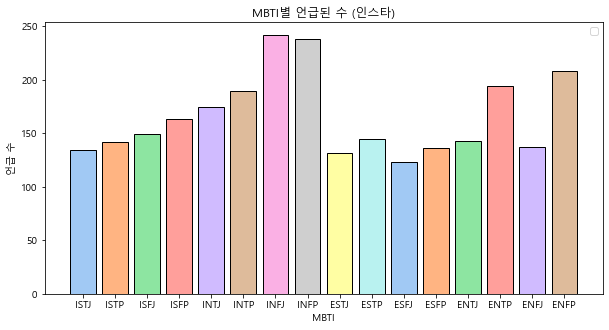

In [12]:
# 그래프 그리기
mbti = []
n = []
for i in range(0,len(count)):
    mbti.append(count[i][0])
    n.append(count[i][1])

plot2(mbti,n,'MBTI별 언급된 수 (인스타)','bar','MBTI','언급 수')

In [13]:
# DB 데이터 조회 불러오기 (INFJ, INFP, ENFP)
top3 = ['infj', 'infp', 'enfp']
idx = 0

top3_df = pd.DataFrame(columns=['mbti','전체게시물', '좋아요 게시물', '1000개이상', '500개이상',  '500개미만'])

for m in top3:
    try:
        cur.execute(f"select * from public.insta_{m};") # sql 문장
        conn.commit()
        mbti_kind = cur.fetchall()
        
        n1,n2,n3 = 0,0,0 # n1 : 1000개이상 n2 : 500개이상 n3 : 나머지
        for i in range(0,len(mbti_kind)):
            if '좋' in mbti_kind[i][3]:
                if int(mbti_kind[i][3][4:-1].replace(',','')) > 999:
                    n1 += 1
                elif int(mbti_kind[i][3][4:-1].replace(',','')) > 499:
                    n2 += 1
                else:
                    n3 += 1
        top3_df.loc[idx] = [m,len(mbti_kind),(n1+n2+n3),n1,n2,n3,]
        idx += 1
          
    except:
        conn.rollback()
        print("--- DB error")

mbti_kind[0][3]

'좋아요 1,245개'

In [14]:
전체대비좋아요 = []
좋아요대비1000 = []
좋아요대비500 = []

# 좋아요 변수 정의 (반올림 작업)
for i in range(0,len(top3_df)):
    a1 = round((top3_df.iloc[i][2]/top3_df.iloc[i][1]*100), 2)
    a2 = round((top3_df.iloc[i][3]/top3_df.iloc[i][1]*100), 2)
    a3 = round(((top3_df.iloc[i][3]+top3_df.iloc[i][4])/top3_df.iloc[i][2]*100), 2)

    전체대비좋아요.append(a1)
    좋아요대비1000.append(a2)
    좋아요대비500.append(a3)

# Dataframe 열 추가
top3_df['전체대비좋아요']=전체대비좋아요
top3_df['좋아요대비1000']=좋아요대비1000
top3_df['좋아요대비500']=좋아요대비500

top3_df

,mbti,전체게시물,좋아요 게시물,1000개이상,500개이상,500개미만,전체대비좋아요,좋아요대비1000,좋아요대비500
0,infj,480,373,37,39,297,77.71,7.71,20.38
1,infp,491,415,43,27,345,84.52,8.76,16.87
2,enfp,495,433,25,29,379,87.47,5.05,12.47


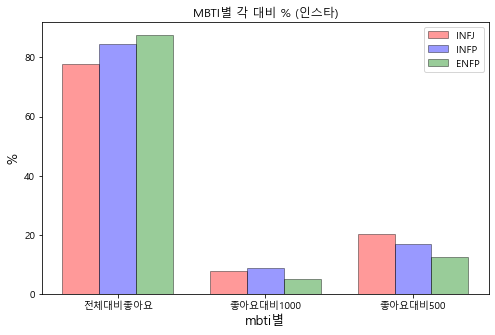

In [15]:
## 그래프 그리기
import matplotlib.pyplot as plt
import numpy as np

# 그림 사이즈, 바 굵기 조정
plt.figure(figsize=(8,5))
bar_width = 0.25

# MBTI가 3개이므로 0, 1, 2 위치를 기준으로 삼음
index = np.arange(3)

# 각 변수별로 3개 bar를 순서대로 나타내는 과정, 각 그래프는 0.25의 간격을 두고 그려짐
b1 = plt.bar(index, list(top3_df.loc[0][6:]), bar_width, alpha=0.4, color='red', label='INFJ',edgecolor='black')

b2 = plt.bar(index + bar_width, list(top3_df.loc[1][6:]), bar_width, alpha=0.4, color='blue', label='INFP',edgecolor='black')

b3 = plt.bar(index + 2 * bar_width, list(top3_df.loc[2][6:]), bar_width, alpha=0.4, color='green', label='ENFP',edgecolor='black')

# x축 위치를 정 가운데로 조정하고 x축의 텍스트를 year 정보와 매칭
plt.xticks(np.arange(bar_width, 3 + bar_width, 1), ['전체대비좋아요','좋아요대비1000','좋아요대비500'])

# x축, y축 이름 및 범례 설정
plt.xlabel('mbti별', size = 13)
plt.ylabel('%', size = 13)
plt.title('MBTI별 각 대비 % (인스타)')
plt.legend()

### YOUTUBE

In [2]:
# 라이브러리
import pandas as pd
from pandas import DataFrame
import openpyxl
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.keys import Keys
import time
import traceback
import requests
from bs4 import BeautifulSoup
from collections import Counter
import matplotlib.pyplot as plt
import platform
import sys
import csv
import numpy as np

# 변수명 일괄 지정
mod = sys.modules[__name__]

# 한글 폰트 오류시
system_name = platform.system()
if system_name == 'Windows':
    # Windows 운영체제
    plt.rc('font', family='Malgun Gothic')
elif system_name == 'Darwin':
    # Mac OS
    plt.rc('font', family='AppleGothic')
elif system_name == 'Linux':
    # Linux
    path = '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf'
    font_name = fm.FontProperties(fname=path, size=12)
    plt.rc('font', family=font_name)
else:
    print("Not support")

* 키워드 검색

In [ ]:
# 유튜브 접속
driver = webdriver.Chrome()
driver.get('https://www.youtube.com/')
time.sleep(2)
driver.maximize_window()

base_url = "https://www.youtube.com/results?search_query="
# 최신순 검색
filter = "&sp=CAI%253D"
search_word = "ENFJ" # MBTI유형 직접 입력
url = base_url + search_word + filter
driver.get(url)
time.sleep(3)

for c in range(0,200):
    driver.find_element_by_tag_name('body').send_keys(Keys.PAGE_DOWN)
    time.sleep(1)

* 크롤링 후 CSV 저장

In [ ]:
df_title = []
df_link = []
df_view = []
df_date = []

html = driver.page_source
soup = BeautifulSoup(html,'html.parser')

for i in range(len(soup.find_all('ytd-video-meta-block', 'style-scope ytd-video-renderer byline-separated'))) :
    title = driver.find_elements_by_xpath('//*[@id="video-title"]')[i].text
    link = 'https://www.youtube.com' + soup.find_all('a', {'id' : 'video-title'})[i]['href']
    view = soup.find_all('ytd-video-meta-block', 'style-scope ytd-video-renderer byline-separated')[i].text.split('•')[1].split('\n')[3]
    date = soup.find_all('ytd-video-meta-block', 'style-scope ytd-video-renderer byline-separated')[i].text.split('•')[1].split('\n')[4]

    df_title.append(title)
    df_link.append(link)
    df_view.append(view)
    df_date.append(date)

df_youtube = pd.DataFrame(columns=['영상제목', '조회수', '업로드', '링크'])

df_youtube['영상제목'] = df_title
df_youtube['조회수'] = df_view
df_youtube['업로드'] = df_date
df_youtube['링크'] = df_link

driver.close()

In [3]:
# 데이터프레임 불러오기
MBTI_list = ['ISTJ', 'ISFJ', 'INFJ', 'INTJ', 'ISTP', 'ISFP', 'INFP', 'INTP', 'ESTP', 'ESFP', 'ENFP', 'ENTP', 'ESTJ', 'ESFJ', 'ENFJ', 'ENTJ']
for i in MBTI_list :
    setattr(mod,'df_{}'.format(i), pd.read_csv('C:/jupyter_notebook/data/df_youtube_%s.csv'%i))

df_INTP

,영상제목,조회수,업로드,링크
0,Ep 350 Explaining INTP behaviour and what an E...,8회,2시간 전,https://www.youtube.com/watch?v=mH-eZQ7_r_E
1,나랑 mbti 같은 캐릭터 / mbti / intp,7회,3시간 전,https://www.youtube.com/watch?v=GTtEXP9q08s
2,[MBTI 케미만화] 30편 - INTP(인팁)과 ENTJ(엔티제) : 연애 최고 궁합,357회,3시간 전,https://www.youtube.com/watch?v=blvgjCFWuuE
3,INTP book stuff and video after 3 months,51회,9시간 전,https://www.youtube.com/watch?v=nsgOvhBqdtI
4,mbti intp-t가 심심하면 생기는 일,7회,10시간 전,https://www.youtube.com/watch?v=g9L3LWmwHk8
...,...,...,...,...
554,��La Personalidad INTP (Español) Parte 1,1.4만회,1년 전,https://www.youtube.com/watch?v=jPhTCeaRKYQ
555,[MBTI-DOL] INTP=게으른 천재? INTP 아이돌 모음 (방탄소년단BTS/...,11만회,1년 전,https://www.youtube.com/watch?v=5_I8NdLp3DQ
556,INTP 성격 유형,29만회,1년 전,https://www.youtube.com/watch?v=mr67ytkvH9Q&pp...
557,Logiker INTP erklärt | 16 Personalities (Deutsch),3.6만회,1년 전,https://www.youtube.com/watch?v=I8aS9-iX8cM


1. MBTI별 업로드 동영상 수 파악

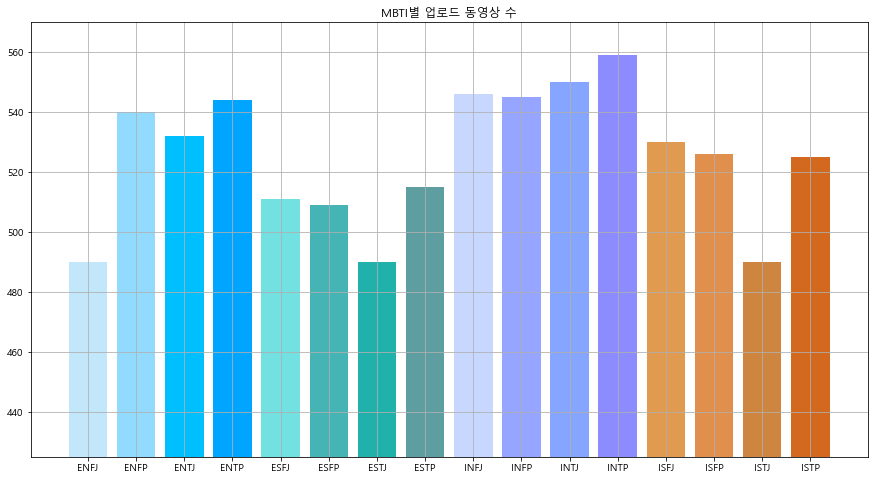

In [3]:
video_count = pd.read_csv('C:/jupyter_notebook/data/count.csv')
color_list = ['#C3E7FA','#93DAFF','#00BFFF','#00A5FF', '#73E1E1', '#46B4B4', '#20B2AA','#5F9EA0','#C8D7FF', '#96A5FF','#86A5FF','#8C8CFF', '#E19B50', '#E0904C', '#CD853F', '#D2691E']

# 시각화
x_axis = video_count.iloc[:,0]
y_axis = video_count.iloc[:,1]

plt.figure(figsize=(15,8))
plt.title('MBTI별 업로드 동영상 수')
plt.ylim(425,570)
plt.bar(x_axis, y_axis, color = color_list)
plt.grid(True)

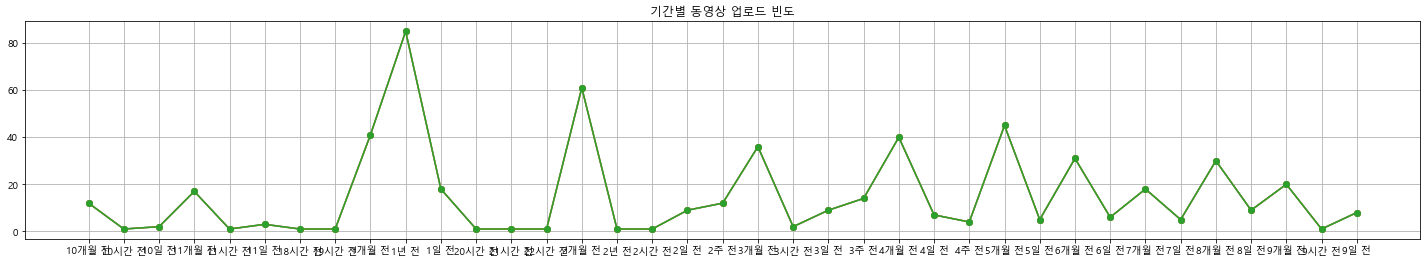

In [4]:
# 기간별 동영상 업로드 빈도 (예시 : Top1 intp)
freq = df_INTP.groupby(['업로드']).count()

plt.figure(figsize=(25,4))
plt.title('기간별 동영상 업로드 빈도')
plt.grid(True)
plt.plot(freq, marker='o', linestyle = '-')
plt.show()

2. Top1, Bottom1 MBTI의 키워드 파악

In [ ]:
top_list = ['INFJ', 'INTJ', 'INTP']
bot_list = ['ENFJ', 'ESTJ', 'ISTJ']

# 타이틀 리스트 만들기
for i in top_list :
    setattr(mod, 'title_{}'.format(i),[])
for i in bot_list :
    setattr(mod, 'title_{}'.format(i),[])

for i in top_list :
    f = open('C:/jupyter_notebook/data/df_youtube_%s.csv'%i, 'r', encoding='utf-8')
    rdr = csv.reader(f)
    for line in rdr:
        getattr(mod, 'title_{}'.format(i)).append(line)
for i in bot_list :
    f = open('C:/jupyter_notebook/data/df_youtube_%s.csv'%i, 'r', encoding='utf-8')
    rdr = csv.reader(f)
    for line in rdr:
        getattr(mod, 'title_{}'.format(i)).append(line)

In [ ]:
# 문자열 분리하여 빈도 카운트
title_ESTJ = [row[0] for row in title_ESTJ]

fre_ESTJ = []
for i in range(1,len(title_ESTJ)) :
    fre_ESTJ.append(title_ESTJ[i].split(' '))

# ...자연어 시간에 이어서

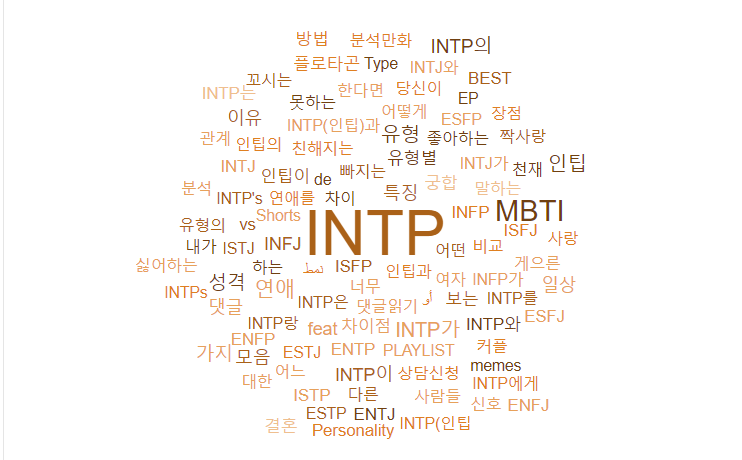

In [5]:
# 예상 워드 클라우드
from IPython.display import Image
Image(r"C:/jupyter_notebook/data/top INTP.png") # code안에서 나오게 할 때

# 트위터

### 1. 코드 소개

In [1]:
import urllib
import urllib.request
from urllib.request import urlopen
import bs4
from bs4 import BeautifulSoup
from selenium import webdriver
import requests
from openpyxl import Workbook
import time
from Scweet.scweet import scrape
import pandas as pd
import xlwt

In [2]:
#데이터 크롤링 + csv 저장
def crl_and_str(mbti) :
    elems = scrape(words=mbti, since='2022-01-01', until='2022-01-31', \
        from_account = None, interval=1, headless=False, display_type='Top', \
        save_images=False, filter_replies=True)


#csv 파일을 판다스로 가져오기
def get_csv(mbti) :
    df = pd.read_csv("C:/jupiterworkspace/outputs/"+mbti+"_2022-01-01_2022-01-31.csv", encoding='utf-8')


#데이터 정제
def purify_df(df) :
    
    #필요없는 열 삭제
    df = df.drop(['UserScreenName', 'UserName', 'Text', 'Image link'], axis=1)
    
    #결측치 = 0
    df['Comments'] = df['Comments'].fillna(0)
    df['Likes'] = df['Likes'].fillna(0)
    df['Retweets'] = df['Retweets'].fillna(0)

    #한국어 -> 숫자
    df['Likes'] = df['Likes'].map(lambda x : replaceText(x))
    df['Retweets'] = df['Retweets'].map(lambda x : replaceText(x))
    
    #datetime 형태로 타입변환
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Timestamp'] = df['Timestamp'].dt.tz_localize(None)

    #요일 열 추가
    df.insert(1, 'Weekday', df['Timestamp'].dt.day_name(), True)

    #광고성 중복행 삭제
    df.drop_duplicates('Embedded_text', keep='first')

    #타입변환
    df = df.astype({'Timestamp' : str, 'Weekday' : str, 'Comments' : int, 'Likes' : int, 'Retweets' : int})
    #df.head()

    return df

#정제한 판다스 데이터프레임을 csv 파일로 저장
def str_csv(mbti) :
    df.to_csv('C:\jupiterworkspace\crl_tp/' + mbti + '.csv')

#천, 만 한국어 보정
def replaceText(text):

    if isinstance(text, int) :
        text=text #0으로 바꾼 결측치 값은 이미 int형태여서 슬라이싱 불가, 그대로 반환
    elif text[-1] == '천' :
        text = float(text[:-1]) * 1000 #2.4천 -> 2.4*1000
    elif text[-1] == '만' :
        text = float(text[:-1]) * 10000 #2.4만 -> 2.4*10000
    
    return int(text)

In [ ]:
#데이터 크롤링 + csv 형태로 저장
mbti_list=['istj', 'istp', 'isfj', 'isfp', 'intj', 'intp', 'infj', 'infp', 'estj', 'estp', 'esfj', 'esfp', 'entj', 'entp', 'enfj', 'enfp']

for mbti in mbti_list :
    crl_and_str(mbti)
    
    df = pd.read_csv("C:/jupiterworkspace/outputs/"+mbti+"_2022-01-01_2022-01-31.csv", encoding='utf-8')
    
    df = purify_df(df)
    
    str_csv(mbti)


In [3]:
#데이터프레임 형태 보여주기 용
mbti = 'enfj'
df = pd.read_csv("C:/jupiterworkspace/outputs/"+mbti+"_2022-01-01_2022-01-31.csv", encoding='utf-8')
df = purify_df(df)
df.head()

,Timestamp,Weekday,Embedded_text,Emojis,Comments,Likes,Retweets,Tweet URL
0,2022-01-01 15:43:10,Saturday,평소 찐 엠비티아이 Entj 인데 찬이랑 원우 나온거 보니 비슷한게 Enfj 로 꽤...,🤔 ✨ ✨ 👉 🤗,0,0,1,https://twitter.com/gomandoooooooo/status/1477...
1,2022-01-01 01:24:21,Saturday,지민아 니가 내 별이고 고양이고 니가 짱이야\n넌 진짜 대박이다 새벽마다 찾아와서 ...,NaN,0,0,0,https://twitter.com/jimimi_enfj/status/1477088...
2,2022-01-01 10:41:01,Saturday,우연히 enfj 갤러리 들어갔다가 나랑 젼나 똑같은 인간들만 있능거 보고 식겁해서 ...,NaN,0,0,4,https://twitter.com/NA_NNAA_/status/1477228361...
3,2022-01-01 10:42:08,Saturday,나만 찐따미 넘치는 사람들 좋아하는줄 알았는데 enfj 대부분이 좋아하나봐ㅋㅋㅋㅋㅋ...,NaN,0,1,5,https://twitter.com/NA_NNAA_/status/1477228643...
4,2022-01-01 09:38:40,Saturday,기선겸 ISTP 같구\n이미주 ENFJ 같다\n와 너무 정반대네 이렇게 다른데 같이...,🌻,1,0,6,https://twitter.com/menuna_nana/status/1477212...


### 2. 그래프 시각화

istj : 1010
istp : 1503
isfj : 1299
isfp : 1429
intj : 1455
intp : 1546
infj : 1478
infp : 1449
estj : 1387
estp : 1412
esfj : 1445
esfp : 1458
entj : 1576
entp : 1924
enfj : 1378
enfp : 1443


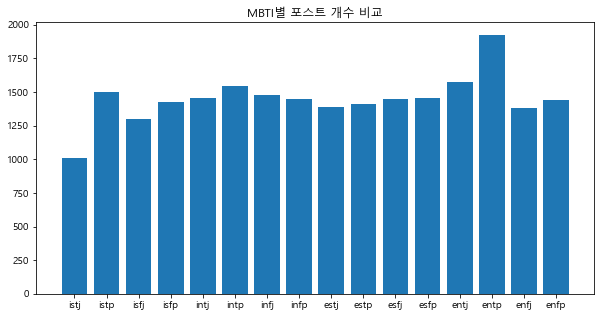

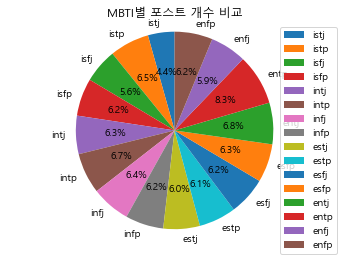

In [4]:
#MBTI 별 포스트 개수 파이차트
import matplotlib.pyplot as plt
import seaborn as sns

mbti_list = ['istj', 'istp', 'isfj', 'isfp', 'intj', 'intp', 'infj', 'infp', 'estj', 'estp', 'esfj', 'esfp', 'entj', 'entp', 'enfj', 'enfp']

count_post=[]

for mbti in mbti_list :
    df = pd.read_csv("C:/jupiterworkspace/outputs/"+mbti+"_2022-01-01_2022-01-31.csv", encoding='utf-8')
    df = purify_df(df)

    a = df.shape[0]
    print(mbti, ':', a)
    count_post.append(a)


#그래프 그리기
plt.rc('font', family='Malgun Gothic')
fig = plt.figure(figsize=(10,5))

plt.bar(mbti_list, count_post)
plt.title('MBTI별 포스트 개수 비교')
plt.show()

plt.pie(count_post, labels=mbti_list, autopct='%.1f%%', startangle=90)
plt.axis('equal')
plt.title('MBTI별 포스트 개수 비교')

plt.legend()
plt.show()


전체 mbti의 평균 포스트 수 : 1449
mbti별 전체 포스트 수 : [1010, 1503, 1299, 1429, 1455, 1546, 1478, 1449, 1387, 1412, 1445, 1458, 1576, 1924, 1378, 1443]
전체 mbti의 평균 좋아요 수 : 20
mbti별 평균 좋아요 수 : [14.0, 10.0, 11.0, 21.0, 9.0, 25.0, 19.0, 31.0, 10.0, 12.0, 6.0, 20.0, 9.0, 30.0, 17.0, 79.0]
전체 mbti의 평균 리트윗 수 : 34
mbti별 평균 리트윗 수 : [20.0, 17.0, 20.0, 24.0, 23.0, 20.0, 29.0, 43.0, 18.0, 21.0, 14.0, 33.0, 18.0, 48.0, 51.0, 153.0]


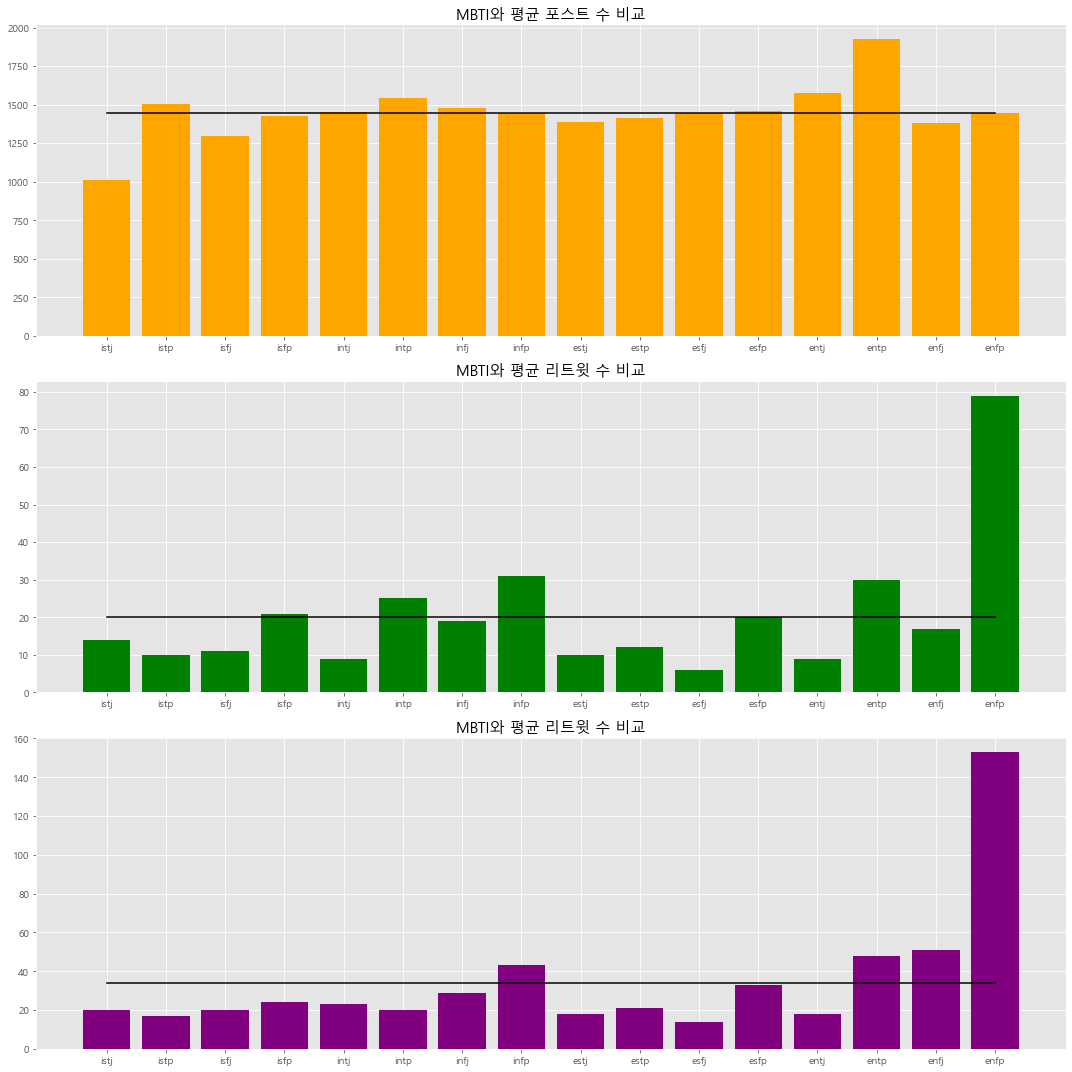

In [5]:
#MBTI 별 포스트, 좋아요, 리트윗 개수 평균과 비교
import matplotlib.pyplot as plt

mbti_list = ['istj', 'istp', 'isfj', 'isfp', 'intj', 'intp', 'infj', 'infp', 'estj', 'estp', 'esfj', 'esfp', 'entj', 'entp', 'enfj', 'enfp']

count_post=[] #MBTI별 포스트 수
sum_like=[] #MBTI별 포스트에 대한 좋아요 수의 합
sum_retweet=[] #MBTI별 포스트에 대한 리트윗 수의 합
avg_like=[] #MBTI별 포스트에 대한 좋아요 수의 평균
avg_retweet=[] #MBTI별 포스트에 대한 리트윗 수의 평균

for mbti in mbti_list :
    df = pd.read_csv("C:/jupiterworkspace/outputs/"+mbti+"_2022-01-01_2022-01-31.csv", encoding='utf-8')
    df = purify_df(df)
    
    count_post.append(df.shape[0])

    sum_like.append(df['Likes'].sum()) 
    sum_retweet.append(df['Retweets'].sum())

    avg_like.append(round(df['Likes'].mean(), 0))
    avg_retweet.append(round(df['Retweets'].mean(), 0))


count_total_post = sum(count_post) #모든 MBTI의 포스트 수의 합
sum_total_like = sum(sum_like) #모든 MBTI의 좋아요 수의 합
sum_total_retweet = sum(sum_retweet) #모든 MBTI의 리트윗 수의 합

avg_total_post = int(count_total_post / 16) #포스트 수의 평균
avg_total_like = int(sum_total_like / count_total_post) #한 포스트 당 평균 좋아요 수
avg_total_retweet = int(sum_total_retweet / count_total_post) #한 포스트 당 평균 리트윗 수

print('전체 mbti의 평균 포스트 수 :', avg_total_post)
print('mbti별 전체 포스트 수 :', count_post)

print('전체 mbti의 평균 좋아요 수 :', avg_total_like)
print('mbti별 평균 좋아요 수 :', avg_like)

print('전체 mbti의 평균 리트윗 수 :', avg_total_retweet)
print('mbti별 평균 리트윗 수 :', avg_retweet)


#그래프 그리기
avg1 = [avg_total_post]*16
avg2 = [avg_total_like]*16
avg3 = [avg_total_retweet]*16

plt.style.use('ggplot')
plt.rc('font', family='Malgun Gothic')
fig = plt.figure(figsize=(15,15))

axes1 = fig.add_subplot(3,1,1)
axes2 = fig.add_subplot(3,1,2)
axes3 = fig.add_subplot(3,1,3)

axes1.bar(mbti_list, count_post, color='orange')
axes2.bar(mbti_list, avg_like, color='green')
axes3.bar(mbti_list, avg_retweet, color='purple')

axes1.plot(mbti_list, avg1, color='black')
axes2.plot(mbti_list, avg2, color='black')
axes3.plot(mbti_list, avg3, color='black')

axes1.set_title('MBTI와 평균 포스트 수 비교', size=15)
axes2.set_title('MBTI와 평균 리트윗 수 비교', size=15)
axes3.set_title('MBTI와 평균 리트윗 수 비교', size=15)

fig.tight_layout()
plt.show()


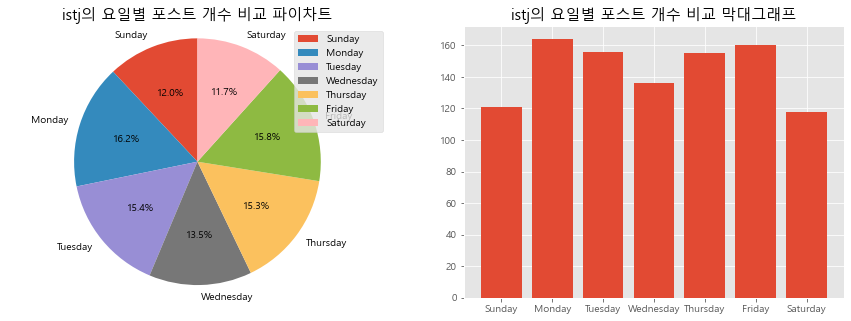

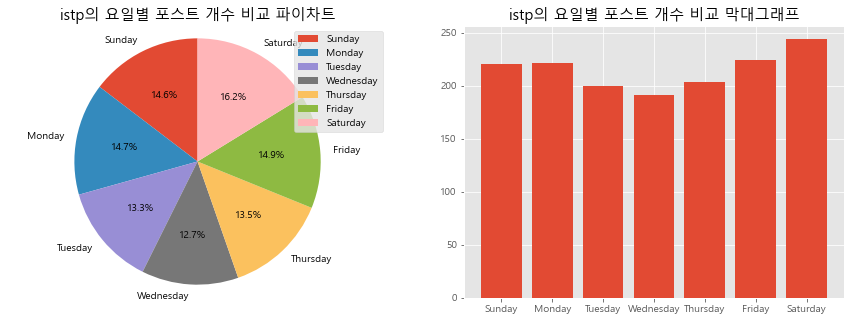

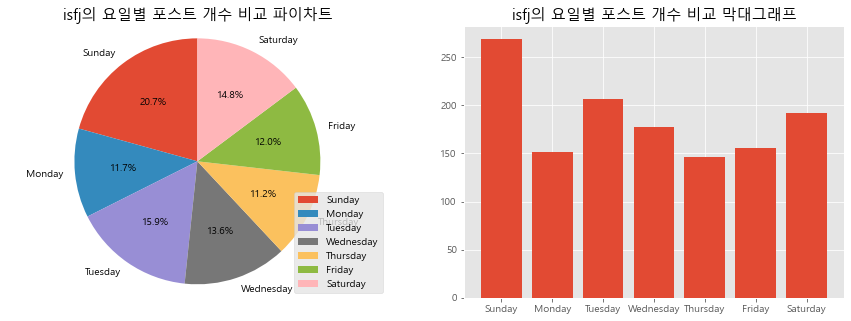

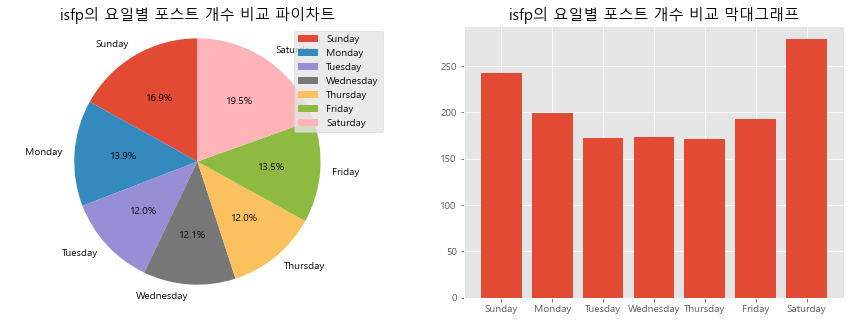

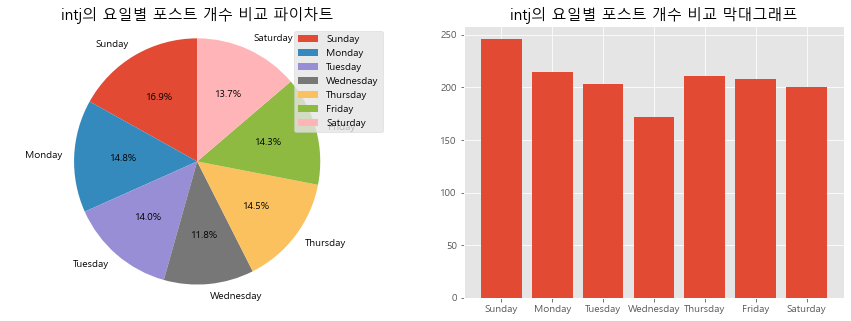

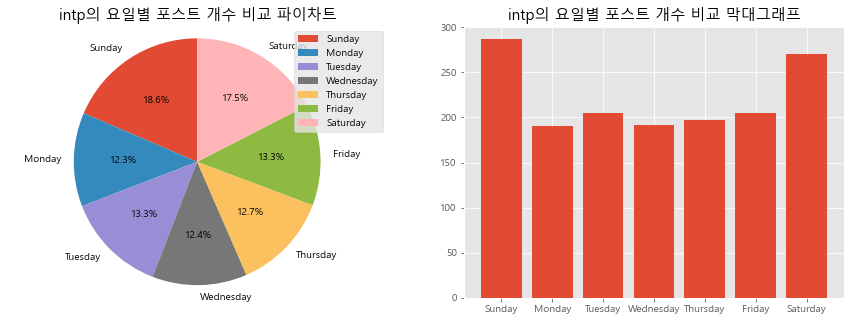

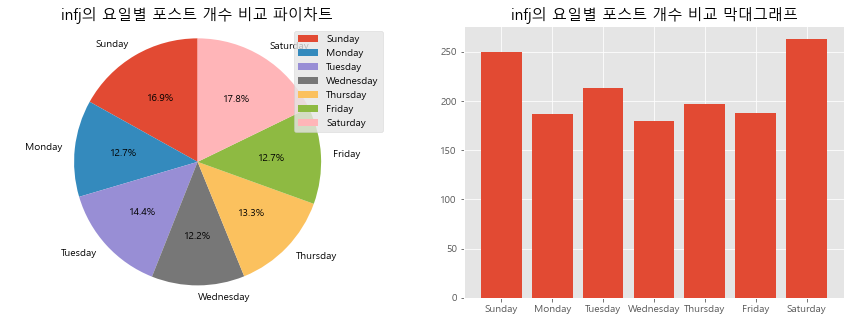

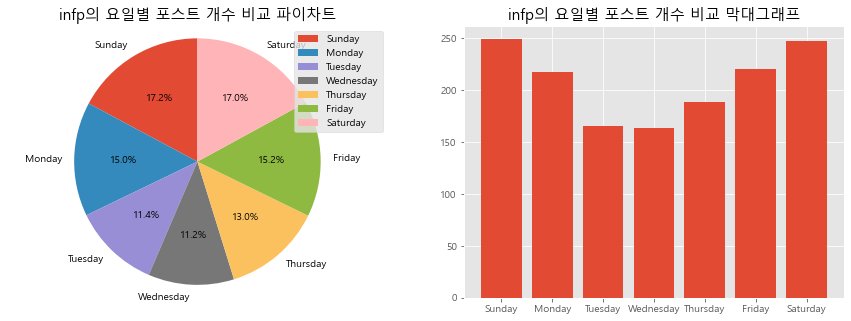

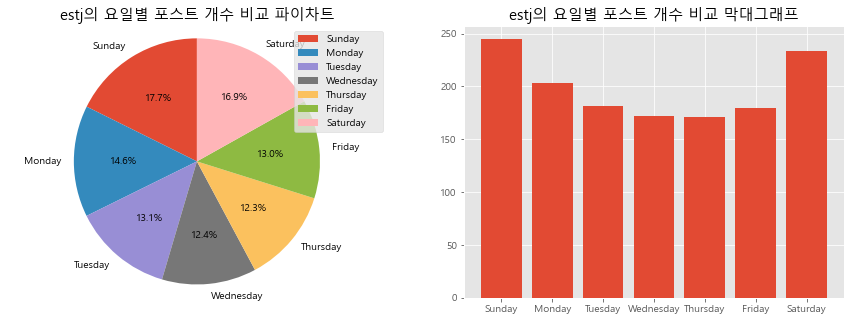

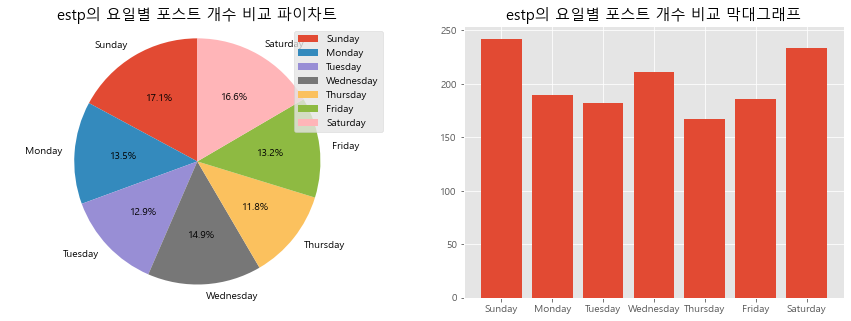

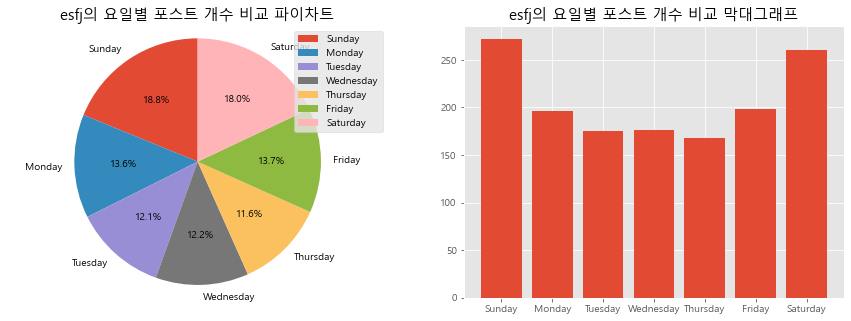

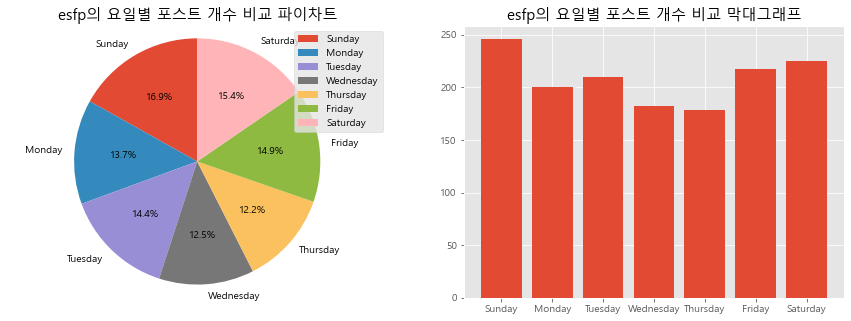

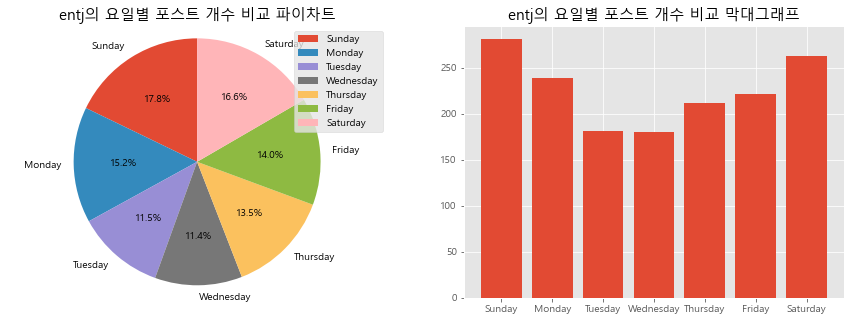

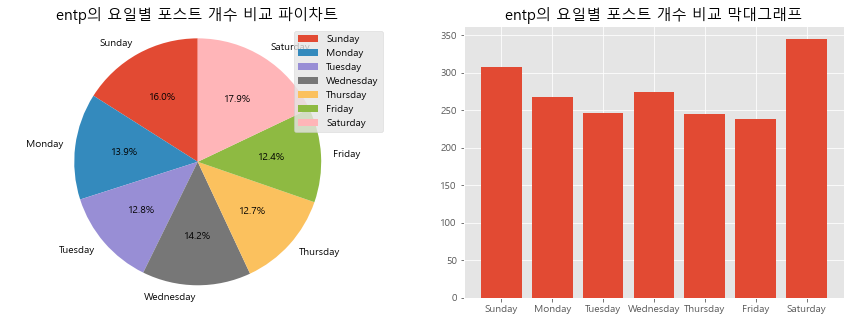

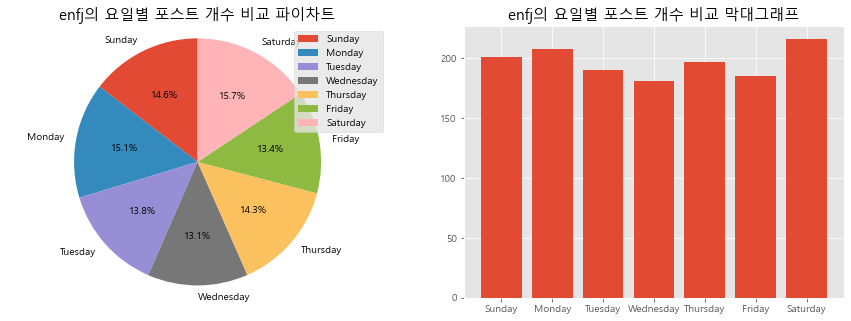

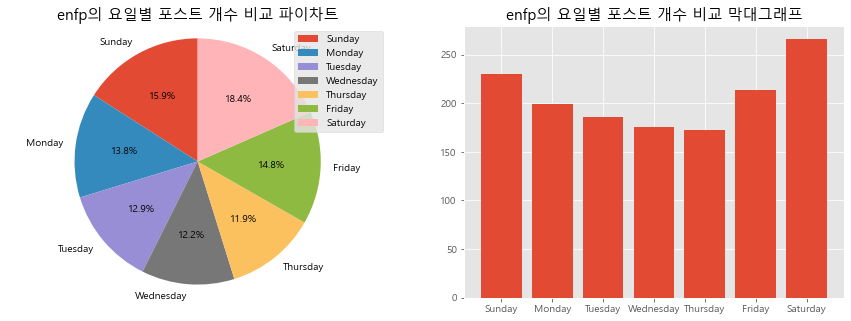

In [6]:
#MBTI 별 업로드 요일 파이차트, 막대그래프
import matplotlib.pyplot as plt

mbti_list = ['istj', 'istp', 'isfj', 'isfp', 'intj', 'intp', 'infj', 'infp', 'estj', 'estp', 'esfj', 'esfp', 'entj', 'entp', 'enfj', 'enfp']

for mbti in mbti_list :
    df = pd.read_csv("C:/jupiterworkspace/outputs/"+mbti+"_2022-01-01_2022-01-31.csv", encoding='utf-8')
    df = purify_df(df)

    weekday_list = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
    weekday_post = [] #MBTI별 요일별 업로드한  포스트 개수 
    
    for weekday in weekday_list :

        a = df[ df['Weekday'] == weekday].count()
        weekday_post.append(a[0])


    #그래프 그리기
    plt.style.use('ggplot')
    plt.rc('font', family='Malgun Gothic')
    fig = plt.figure(figsize=(15,5))

    axes1 = fig.add_subplot(1,2,1)
    axes2 = fig.add_subplot(1,2,2)

    axes1.pie(weekday_post, labels=weekday_list, autopct='%.1f%%', startangle=90)
    axes1.axis('equal')
    axes1.set_title(mbti + '의 요일별 포스트 개수 비교 파이차트', size=15)
    axes1.legend()

    axes2.bar(weekday_list, weekday_post)    
    axes2.set_title(mbti + '의 요일별 포스트 개수 비교 막대그래프', size=15)

    plt.show()


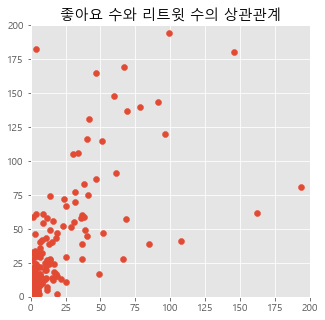

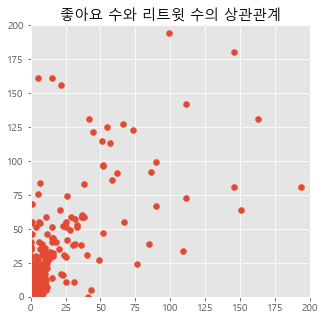

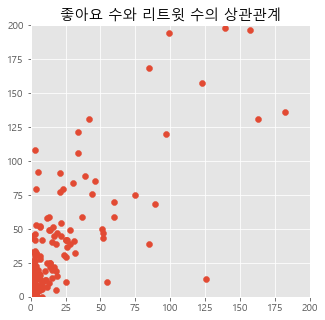

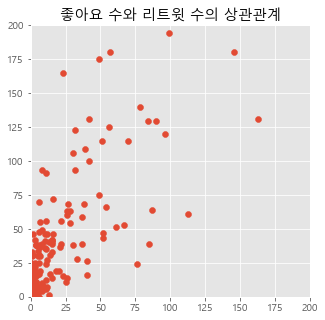

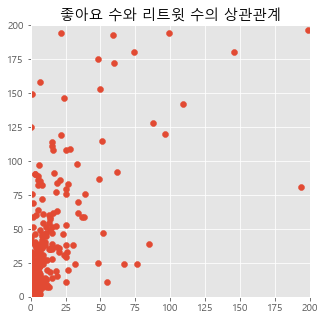

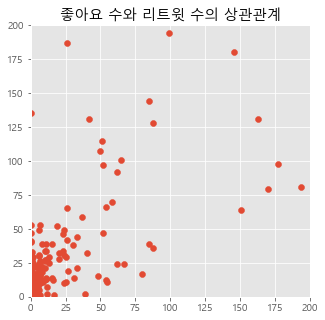

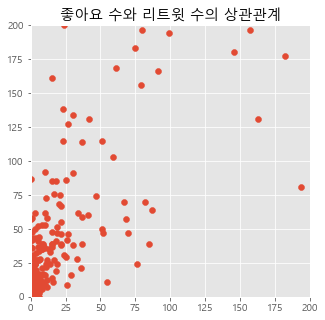

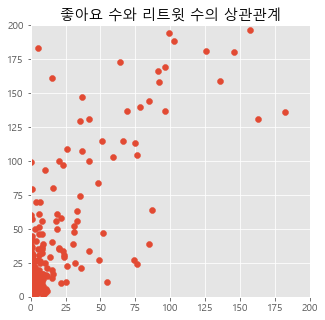

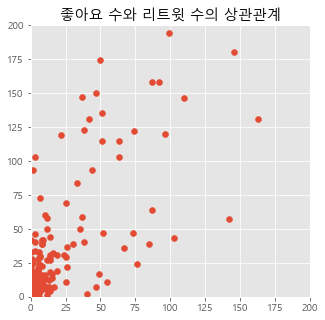

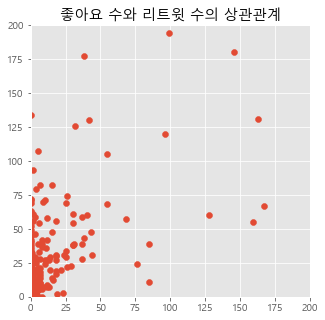

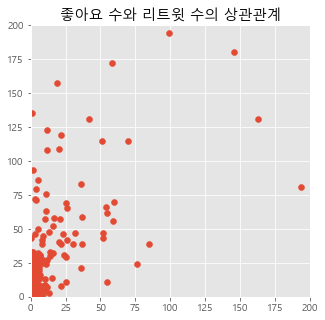

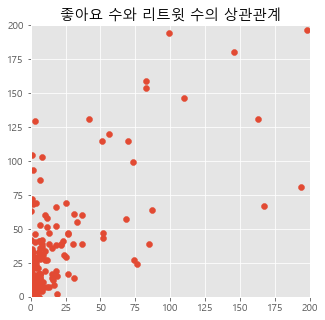

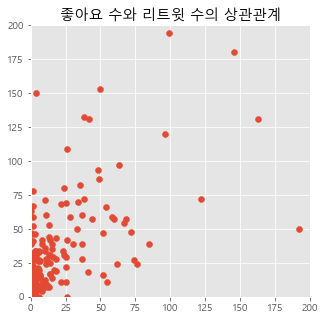

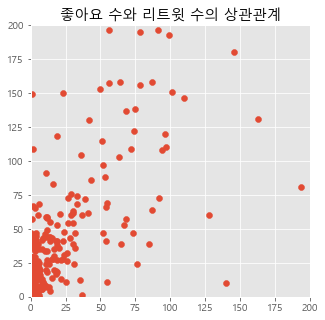

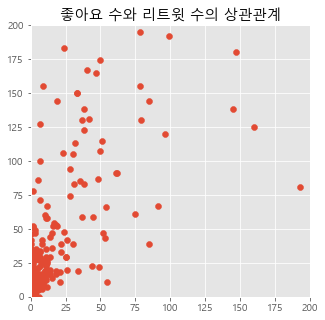

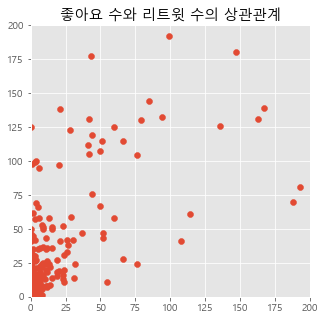

In [7]:
#좋아요와 리트윗 간의 산점도 + 추세선
import matplotlib.pyplot as plt

mbti_list = ['istj', 'istp', 'isfj', 'isfp', 'intj', 'intp', 'infj', 'infp', 'estj', 'estp', 'esfj', 'esfp', 'entj', 'entp', 'enfj', 'enfp']

for mbti in mbti_list :
    df = pd.read_csv("C:/jupiterworkspace/outputs/"+mbti+"_2022-01-01_2022-01-31.csv", encoding='utf-8')
    df = purify_df(df)

    S_like = df['Likes'] #특정 MBTI의 좋아요 시리즈
    L_like = S_like.values.tolist() #특정 MBTI의 좋아요 리스트
    S_retweet = df['Retweets'] #특정 MBTI의 리트윗 시리즈
    L_retweet = S_retweet.values.tolist() #특정 MBTI의 리트윗 리스트


    #그래프 그리기
    plt.style.use('ggplot')
    plt.rc('font', family='Malgun Gothic')
    fig = plt.figure(figsize=(5, 5))

    plt.scatter(L_like, L_retweet, cmap='seismic')
    plt.title('좋아요 수와 리트윗 수의 상관관계')
    
    plt.xlim(0, 200)
    plt.ylim(0, 200)

    plt.show()

### 3. 시도했던 것

- 트위터 홈에서부터 검색 >> 검색어 버튼이 없어서 포기

In [ ]:
#entj만 검색
driver = webdriver.Chrome('chromedriver.exe')
driver.get("https://twitter.com/home")

#driver.maximize_window() # 창 최대화

time.sleep(3)

#id 입력창
#<div dir="auto" class="css-901oao r-1awozwy r-18jsvk2 r-6koalj r-37j5jr r-1inkyih r-16dba41 r-135wba7 r-bcqeeo r-13qz1uu r-qvutc0">
# <input autocapitalize="sentences" autocomplete="username" autocorrect="on" name="text" spellcheck="true" type="text" dir="auto" 
# class="r-30o5oe r-1niwhzg r-17gur6a r-1yadl64 r-deolkf r-homxoj r-poiln3 r-7cikom r-1ny4l3l r-t60dpp r-1dz5y72 r-fdjqy7 r-13qz1uu" 
# value=""></div>
id = driver.find_element(By.CLASS_NAME, "r-30o5oe")
#By.
id.click()
id.send_keys('eellddeeii')

# 검색버튼 위치 정보
#<div role="button" tabindex="0" class="css-18t94o4 css-1dbjc4n r-sdzlij r-1phboty r-rs99b7 r-ywje51 r-usiww2 r-2yi16 r-1qi8awa r-1ny4l3l 
# r-ymttw5 r-o7ynqc r-6416eg r-lrvibr r-13qz1uu" style="background-color: rgb(15, 20, 25); border-color: rgba(0, 0, 0, 0);">
# <div dir="auto" class="css-901oao r-1awozwy r-6koalj r-18u37iz r-16y2uox r-37j5jr r-a023e6 r-b88u0q r-1777fci r-rjixqe r-bcqeeo r-q4m81j 
# r-qvutc0" style="color: rgb(255, 255, 255);"><span class="css-901oao css-16my406 css-bfa6kz r-poiln3 r-a023e6 r-rjixqe r-bcqeeo r-qvutc0">
# <span class="css-901oao css-16my406 r-poiln3 r-bcqeeo r-qvutc0">다음</span></span></div></div>
elem = driver.find_element_by_class_name('css-901oao')
elem.click() # 검색 버튼 클릭.

# <button id="search_btn" type="submit" title="검색" tabindex="3" class="btn_submit"
# onclick="window.nclick(this,'sch.action','','',event);" style="">
# <span class="blind">검색</span>
# <span class="ico_search_submit"></span>
# </button>



# 검색어 입력창
# <div dir="auto" class="css-901oao r-18jsvk2 r-6koalj r-37j5jr r-a023e6 r-16dba41 r-rjixqe r-bcqeeo r-qvutc0">
# <input aria-activedescendant="typeaheadFocus-0.6184915028694735" aria-autocomplete="list" aria-label="Search query" 
# aria-owns="typeaheadDropdown-6" autocapitalize="sentences" autocomplete="off" autocorrect="off" placeholder="Search Twitter" 
# role="combobox" spellcheck="false" enterkeyhint="search" type="text" dir="auto" class="r-30o5oe r-1niwhzg r-17gur6a r-1yadl64 r-deolkf 
# r-homxoj r-poiln3 r-7cikom r-1ny4l3l r-xyw6el r-y0fyvk r-1dz5y72 r-fdjqy7 r-13qz1uu" data-testid="SearchBox_Search_Input" value="
# " aria-expanded="true" autofocus=""></div>
# <input aria-activedescendant="typeaheadFocus-0.6184915028694735" aria-autocomplete="list" aria-label="Search query" 
# aria-owns="typeaheadDropdown-6" autocapitalize="sentences" autocomplete="off" autocorrect="off" placeholder="Search Twitter" 
# role="combobox" spellcheck="false" enterkeyhint="search" type="text" dir="auto" class="r-30o5oe r-1niwhzg r-17gur6a r-1yadl64 r-deolkf 
# r-homxoj r-poiln3 r-7cikom r-1ny4l3l r-xyw6el r-y0fyvk r-1dz5y72 r-fdjqy7 r-13qz1uu" data-testid="SearchBox_Search_Input" value="
# " aria-expanded="true" autofocus="">
elem = driver.find_element(By.CLASS_NAME, 'r-30o5oe r-1niwhzg r-17gur6a r-1yadl64 r-deolkf r-homxoj r-poiln3 r-7cikom r-1ny4l3l r-xyw6el r-y0fyvk r-1dz5y72 r-fdjqy7 r-13qz1uu')
elem.send_keys('ENTJ')



- 검색까지 된 창에서 크롤링 시도 >> 크롤링을 하려니 검색어 전 텍스트 / 검색어 / 검색어 후 텍스트가 따로 저장되어 있어서 포기

In [ ]:

"""
#https://twitter.com/search?q=isfp&src=typed_query&f=top
search_word = input('검색어 입력')
base_url = 'https://twitter.com/search?q='
url = base_url + search_word + '&src=typed_query&f=top'
"""

#isfp만 검색
url = 'https://twitter.com/search?q=isfp&src=typed_query&f=top'

#driver.maximize_window() # 창 최대화

#url 가져오기 오류 보정
response = requests.get(url)

if response.status_code == 200 : #정상
    html = response.text
    soup = BeautifulSoup(html, 'html.parser')
    
    pos = "#react-root > div > div > div.css-1dbjc4n.r-18u37iz.r-13qz1uu.r-417010 > main > div > div > div > div.css-1dbjc4n.r-14lw9ot.r-jxzhtn.r-1ljd8xs.r-13l2t4g.r-1phboty.r-1jgb5lz.r-11wrixw.r-61z16t.r-1ye8kvj.r-13qz1uu.r-184en5c > div > div:nth-child(2) > div > section > div > div"
    #<div lang="en" dir="auto" class="css-901oao r-18jsvk2 r-37j5jr r-a023e6 r-16dba41 r-rjixqe r-bcqeeo r-bnwqim r-qvutc0" id="id__cp12ar6u5b"><span class="css-901oao css-16my406 r-poiln3 r-b88u0q r-bcqeeo r-qvutc0">isfp</span><span class="css-901oao css-16my406 r-poiln3 r-bcqeeo r-qvutc0"> the best</span></div>
    divs = soup.select(pos) # 리스트 출력
    print(divs)
    #print(type(divs))

    #trs = divs.find_all('css-901oao') # <tr> 영역 배열에 넣기
    #print(trs)

#<span class="css-901oao css-16my406 r-poiln3 r-bcqeeo r-qvutc0">Ooh another 20+ follow party! </span>
else :
    print(response.status_code)


- 트위터 api 사용 >> api로 접속가능한 라이브러리를 사용했으나 원하는 만큼의 데이터가 나오지 않아 포기

In [ ]:
twitter_consumer_key = "zoAQsNx4rRPwb1co1d39Fn0F3"
twitter_consumer_secret = "PaqlxxKmWGulHUWkNXpZZe2CABo13WukHerpGA0sLfNIrNRBq9"  
twitter_access_token = "1443424139700686849-WkEmjNWo2RY37fu9xH2jnqFhPBSJpX"
twitter_access_secret = "GRMezs9gA2Qk8ni3vf2UA69Gbha9NkmFXkCjMWSRXMnjX"

import twitter

twitter_api = twitter.Api(consumer_key=twitter_consumer_key,
                          consumer_secret=twitter_consumer_secret, 
                          access_token_key=twitter_access_token, 
                          access_token_secret=twitter_access_secret)

query = "코로나"
statuses = twitter_api.GetSearch(term=query, count=10)

for status in statuses:
    print(status.text)

- 워드클라우드 생성  >> konlpy 설치가 안돼서 포기

In [ ]:
from konlpy.tag import Okt
from collections import Counter
import pandas as pd

mbti = 'istj'
df = pd.read_csv("C:/jupiterworkspace/outputs/"+mbti+"_2022-01-01_2022-01-31.csv", encoding='utf-8')

twitter = Okt()
noun_adj_adv_list = []

for tweet in df['Embedded_text'] :
    for s, p in twitter.pos(tweet) :
        if p in ['Noun', 'Adjective', 'Adverb'] :
            noun_adj_adv_list.append(s)

count = Counter(noun_adj_adv_list)
words = dict(count.most_common()) #빈도수 대로 단어 정렬 & 딕셔너리화
print(words)


- DB에서 파일을 읽어와서 워드클라우드 생성 >> wordcloud 설치가 안돼서 포기

In [ ]:
# DB 데이터 불러오기
try:
    cur.execute("select embedded_text from public.enfj;") # sql 문장
    conn.commit()
    text = cur.fetchall()
    
except:
    conn.rollback()
    print("--- DB error")

print(type(text))

plt.rc('font', family='Malgun Gothic')
plt.figure(figsize=(4, 4))
plt.plot([1, 4], [0, 0], label='한글 설정을 완료했습니다')
plt.legend()
plt.show()

- 워드클라우드 홈페이지에서 작업  >> 데이터는 많은데 시간이 없어서 포기

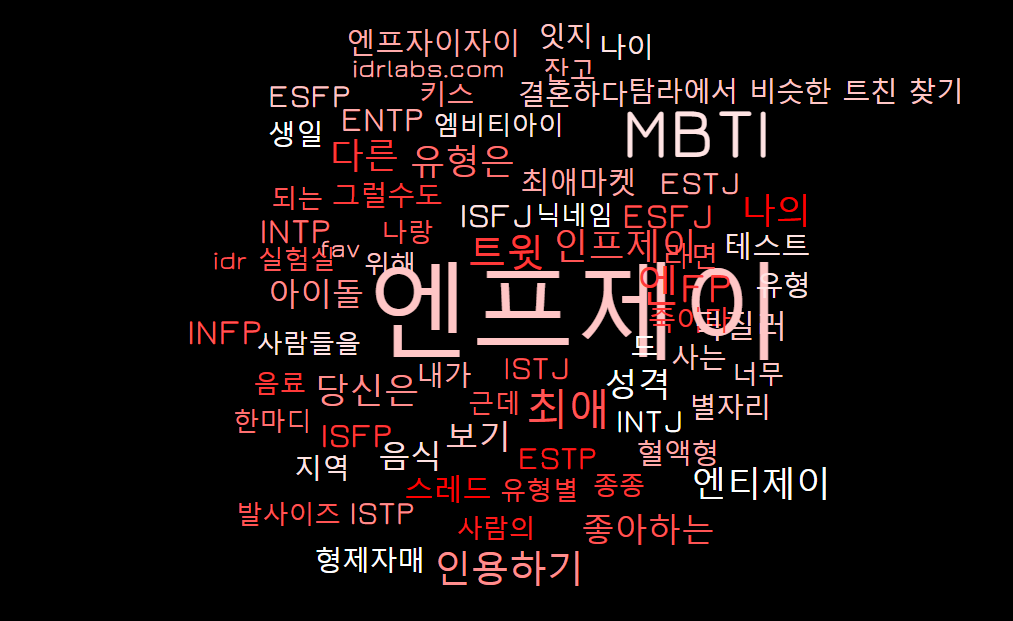

In [8]:
from IPython.display import Image
 
Image(r"C:\Users\q\Desktop\빅분양\7 크롤링, 정제\미니프로젝트\enfj.png") # code안에서 나오게 할 때

### 도서 API

In [2]:
client_id = "SFBVy_Sps38LXkNxHNoq"
client_secret = "zlixlrNhi3"

query = urllib.parse.quote(input('검색할 단어'))
display = 100
start = 1
end = 1000
idx = 0
sort = 'sim'

df = pd.DataFrame(columns=['Title', 'Link',  'Publisher', 'Isbn', 'Pubdate', 'Description'])

for start_index in range(start, end, display):
    url = "https://openapi.naver.com/v1/search/book?query=" + query + \
        "&display=" + str(display) + \
        "&start=" + str(start_index) + \
        "&sort=" + sort
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id", client_id)
    request.add_header("X-Naver-Client-Secret", client_secret)
    response = urllib.request.urlopen(request)
    rescode = response.getcode()
    if (rescode == 200):
        response_body = response.read()
        items = json.loads(response_body.decode('utf-8'))["items"]
        remove_tag = re.compile('<.*?>')
        for item_index in range(0, len(items)):
            title = re.sub(remove_tag, '', items[item_index]['title'])
            link = items[item_index]['link'] # 제목
            image = items[item_index]['image'] # 썸네일 이미지의 URL
            author = items[item_index]['author'] # 저자
            price = items[item_index]['price'] # 정가
            discount = items[item_index]['discount'] # 할인가격
            publisher = items[item_index]['publisher'] # 출판사
            isbn = items[item_index]['isbn'] # 국제표준도서번호(ISBN) 넘버
            description = re.sub(remove_tag, '', items[item_index]['description']) # 검색결과 문서의 내용 요약
            pubdate = items[item_index]['pubdate'] # 출간일

            df.loc[idx] = [title, link, publisher, isbn, pubdate, description]
            idx += 1
    else:
        print("Error Code: " + rescode)

df.loc[0:3]

,Title,Link,Publisher,Isbn,Pubdate,Description
0,흔한남매 흔한 MBTI (믿거나 말거나 나에게 어울리는 직업),http://book.naver.com/bookdb/book_detail.php?b...,대원키즈,1136273794 9791136273796,20210901,흔한남매와 함께 떠나는MBTI 유형별 직업 여행『흔한 MBTI』는 널리 알려진 MB...
1,우리들의 MBTI (나의 성격을 이해하고 더 멋진 내가 되는),http://book.naver.com/bookdb/book_detail.php?b...,다산어린이,1130639401 9791130639406,20210726,MBTI는 성격 유형마다 타고난 강점을 활용하고 단점을 보완하면서 성장할 수 있는 ...
2,나의 MBTI가 궁금하단 마리몽,http://book.naver.com/bookdb/book_detail.php?b...,더모던,1164455354 9791164455355,20211130,"여러분의 MBTI는 무엇입니까?\n\n혈액형 A형은 소심하고, O형은 활발하다고 유..."
3,MBTI의 의미 (MBTI는 과학인가?),http://book.naver.com/bookdb/book_detail.php?b...,하움출판사,1164407112 9791164407118,20201119,&quot;MBTI는 과학적인가?&quot; 이 질문에 대한 나의 대답은 이것이다....


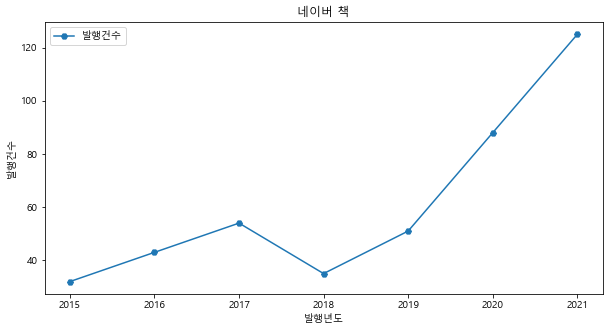

In [5]:
# 데이터 정제
date = {'2015':0,'2016':0,'2017':0,'2018':0,'2019':0,'2020':0,'2021':0}
date_k = list(date.keys())

for i in range(0,len(df)):
    for j in range(0,len(date_k)):
        if date_k[j] in df['Pubdate'][i]:
            date[date_k[j]] += 1

date_v = list(date.values())

# 그래프 그리기
plot2(date_k, date_v, '네이버 책','line','발행년도','발행건수')